<a href="https://colab.research.google.com/github/soyeunju/ESAA/blob/main/25-1/Assignments/0407_Week6_HW_PGML_TextAnalysis_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 파머완 ch8. 10-11

p.566-583

## **10. 텍스트분석 실습 - 캐글 Mercari Price Suggestion Challenge**
- 일본의 대형 온라인 쇼핑몰 Mercari사의 제품 가격 예측
- 데이터 세트: 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터
  - 제품 예상 가격을 판매자에게 제공하고자 함
  * trainid: 데이터 id
  * name: 제품명
  * item_conditionjd: 판매자가 제공하는 제품 상태
  * category_name: 카테고리 명
  * brand_name: 브랜드 이름
  * price: 제품 가격. 예측을 위한 **타깃 속성**
  * shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
  * item_description: 제품에 대한 설명

### **데이터 전처리**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA OB/datasets/mercari_train.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name: Null 많음
- category_name: 약 6300건의 Null
- item_description: 4건의 Null

**Target(Price) 데이터 분포도 확인**
- 회귀에서 Target의 정규 분포도는 매우 중요함
- 일반적으로 로그 씌워서 변환하면 대부분 정규분포 형태 가지게 됨

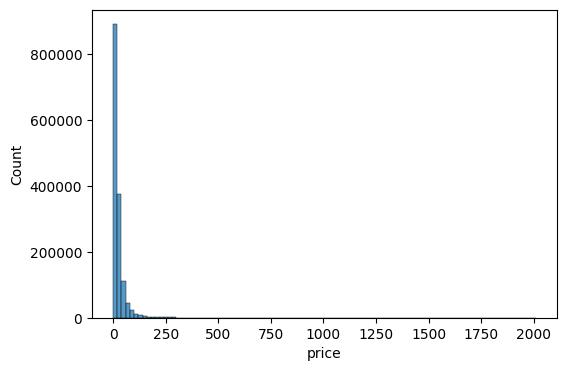

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

- 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포

  ➡️ 로그 변환한 뒤 분포 다시 살펴보자

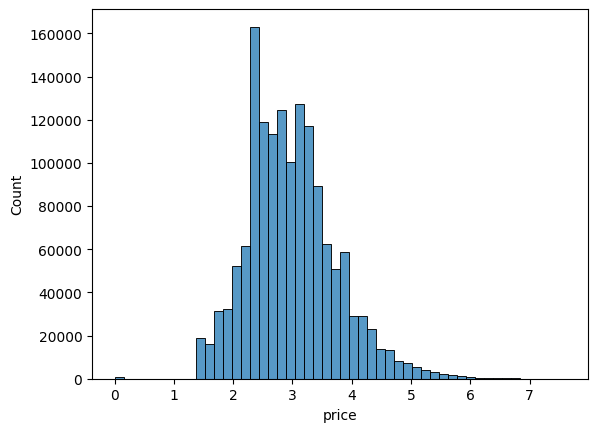

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

- 비교적 정규분포에 가까운 데이터가 됨
- 데이터 세트의 price 칼럼을 로그 변환된 값으로 변경

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head()

,price
0,2.397895
1,3.970292
2,2.397895
3,3.583519
4,3.806662


**Shipping, item_condition_id**

In [7]:
print('Shpping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\nitem_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shpping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64

item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- Shipping: 배송비 유무, 비교적 균일한 값
- item_condition_id: 판매자가 제공하는 제품 상태(각 값이 의미하는 바는 기재 X), 주로 1,2,3

**item_description**

In [8]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

- item_description: Null 값은 적지만, 별도 설명이 없는 경우 `'No description yet'`

**category_name**
- `'/'`로 분리된 카테고리를 하나의 문자열로 나타냄
  
  ex. 'Men/Tops/T-shirts'
  - 피처 추출 시 tokenizer를 '/'로 하여 단어 분리 -> 벡터화도 가능
  - 여기서는 '/'를 기준으로 단어 토큰화 -> 별도의 피처로 저장 후 알고리즘 학습에 이용
- split_cat() 함수
  - 약 6300건의 Null값에 유의
  - `zip()`: iterable 객체에서 같은 위치에 있는 요소끼리 묶기
  - `'*'`: unpacking 연산자

In [9]:
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


**결측치 처리**
- brand_name, category_name, item_description의 Null -> 'Other Null'로 동일하게 변경
  - brand_name은 price 값 결정에 영향을 많이 줄 것으로 판단되지만 Null 값이 매우 많음
  - 아쉽게도 Null 값을 다른 값으로 변경하는 것은 적절하지 않을 것으로 판단되므로 일괄 변경

In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


### **피처 인코딩과 피처 벡터화**
- 문자열 칼럼이 많음
  - 레이블/원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼 선별하기
- Price 값 예측 = 회귀 모델 기반
  - 선형 회귀, 회귀 트리 모델 모두 적용 예정
  - 선형 회귀: 원-핫 인코딩이 훨씬 선호됨

    => 모든 인코딩할 피처는 원-핫 인코딩 적용
- 짧은 텍스트 -> Count 기반 벡터화, 긴 텍스트: TD-IDF 기반 벡터화 적용

**brand_name**

In [11]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건:', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건: brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- 대부분 명료한 문자열
- 별도의 피처 벡터화 형태 필요 없이 인코딩 적용
  - brand_name 종류가 총 4810건으로 원-핫 인코딩 변환하기에 다소 많아 보이지만, ML 모델 구축상 큰 문제는 없음

**name**

In [12]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'][:7])

name의 종류 개수: 1225273
name sample 7건:
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- 종류가 매우 많음
  - 전체 데이터가 1,482,535개 => 거의 고유한 상품명을 가짐
- 유형이 많고, 적은 단어 위주의 텍스트 형태 => Count 기반 피처 벡터화 적용

**category_name**
- 전처리를 통해 대, 중, 소 분류 3개의 칼럼으로 분리 => 원-핫 인코딩 적용

**shipping**
- 0, 1 두 가지 유형의 값

**item_condition**
- 1,2,3,4,5 다섯 가지 유형의 값

  ➡️ 모두 원-핫 인코딩

**item_description**
- 데이터 세트에서 가장 긴 텍스트

In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 평균 문자열이 145로 비교적 큼 => TF-IDF 변환

**인코딩, 피처 벡터화 변환 적용**

In [14]:
# name 속성 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizer, TfidfVectorizer가 `fit_transform()`으로 반환하는 데이터 -> 희소 행렬 형태
- X_name과 X_desp를 새로 결합해 새로운 데이터 세트로 구성
  - 앞으로 인코딩될 피처들도 모두 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성

  ➡️ 인코딩 대상 칼럼도 밀집(X), 희소(O) 행렬 형태로 인코딩 적용한 뒤 함께 결합
- 사이킷런의 원-핫 인코딩 클래스: `OneHotEncoder`, `LabelBinarizer`
  - LabelBinarizer: 희소 행렬 형태의 원-핫 인코딩 변환을 지원
    - `sparse_out=True`
  - sparse 모듈의 `hstack()` 함수를 이용해 결합
    - 개별 칼럼으로 만들어진 희소 행렬 -> 칼럼 레벨로 결합할 수 있게 함

  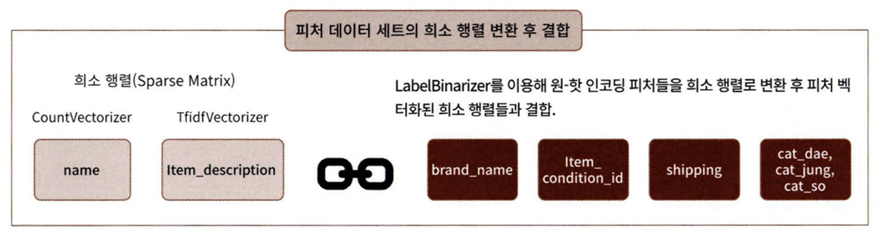

In [15]:
from sklearn.preprocessing import LabelBinarizer

# bran_name, item_condition_id, shipping 각 피처를 희소행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처를 희소행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_dae.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_dae.fit_transform(mercari_df['cat_so'])

In [16]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape: {0}, X_tiem_cond_id shape: {1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape: {0}, X_cat_dae shape: {1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape: {0}, X_cat_so shape: {1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_tiem_cond_id shape: (1482535, 5)
X_shipping shape: (1482535, 1), X_cat_dae shape: (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape: (1482535, 871)


In [17]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

In [18]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [19]:
import gc
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)

    del X , X_train , X_test , y_train
    gc.collect()

    return preds , y_test

In [20]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.49841979469206193
Item Description을 포함한 rmsle 값: 0.46800085128398006


In [26]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 326.944733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068409
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM rmsle 값: 0.4648098595769785


In [27]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4502329276147259
